In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

df = pd.read_csv('./contributions.csv')
# df.head()

subscriber_id          304039
network                304039
date_joined            304039
cycle_type             304039
subscription_status    304039
cycle_min_amount       304039
amount_contributed     304039
transaction_date       304039
transaction_status     304039
status_reason          303948
contribution_type      304039
dtype: int64

### Total Contributors vs Contributors Who Have Cancelled

In [48]:
all_contributions = df['subscriber_id'].nunique()
all_contributions

3159

In [59]:
cancelled_df = df[df['subscription_status'].str.lower() == 'cancelled']
cancelled_users = cancelled_df['subscriber_id'].nunique()
cancelled_users

537

### Cancellation Analysis

df['date_joined'] = pd.to_datetime(df['date_joined'])
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

In [ ]:
cancelled_df = df[df['subscription_status'].str.lower() == 'cancelled']

first_cancellations = cancelled_df.groupby('subscriber_id')['transaction_date'].min().reset_index()
first_cancellations = first_cancellations.rename(columns={'transaction_date': 'cancel_date'})
# first_cancellations

joined_dates = df[['subscriber_id', 'date_joined']].drop_duplicates()
cancel_analysis = pd.merge(first_cancellations, joined_dates, on='subscriber_id')
# cancel_analysis


In [ ]:
cancel_analysis['cancel_date'] = pd.to_datetime(cancel_analysis['cancel_date'])
cancel_analysis['date_joined'] = pd.to_datetime(cancel_analysis['date_joined'])
cancel_analysis['hours_until_cancel'] = (cancel_analysis['cancel_date'] - cancel_analysis['date_joined']).dt.total_seconds() / 3600

average_cancel_days = cancel_analysis['hours_until_cancel'].mean()
print(f"Average time until cancellation: {average_cancel_days:.2f} Hours")

Average time until cancellation: 35.07 Hours


In [ ]:
cancellations_under_a_day = cancel_analysis[cancel_analysis['hours_until_cancel'] < 24].count()
print(f"Contributors Who Cancelled Within A Day: {cancellations_under_a_day['subscriber_id']}")

Contributors Who Cancelled Within A Day: 499


In [ ]:

cancellations_under_an_hour = cancel_analysis[cancel_analysis['hours_until_cancel'] < 1].count()
print(f"Contributors Who Cancelled Under An Hour or Made no initial contributions: {cancellations_under_an_hour['subscriber_id']}")

Contributors Who Cancelled Under An Hour or Made no initial contributions: 454


#### Analyzing Cancellations on Weekly

In [ ]:
cancelled = df[df['subscription_status'] == 'cancelled'].copy()
cancelled['date_joined'] = pd.to_datetime(cancelled['date_joined'])
cancelled['cancel_date'] = pd.to_datetime(cancelled['transaction_date'])
cancelled['joined_week'] = cancelled['date_joined'].dt.isocalendar().week
cancelled['cancel_week'] = cancelled['cancel_date'].dt.isocalendar().week

cancelled['joined_month'] = cancelled['date_joined'].dt.month
cancelled['cancel_month'] = cancelled['cancel_date'].dt.month
same_week = cancelled[cancelled['joined_week'] == cancelled['cancel_week']]
same_month = cancelled[cancelled['joined_month'] == cancelled['cancel_month']]
print("Cancelled in same week:", same_week['subscriber_id'].nunique())
print("Cancelled in same month:", same_month['subscriber_id'].nunique())


Cancelled in same week: 511
Cancelled in same month: 525


### Measuring Cancellations Over TIme

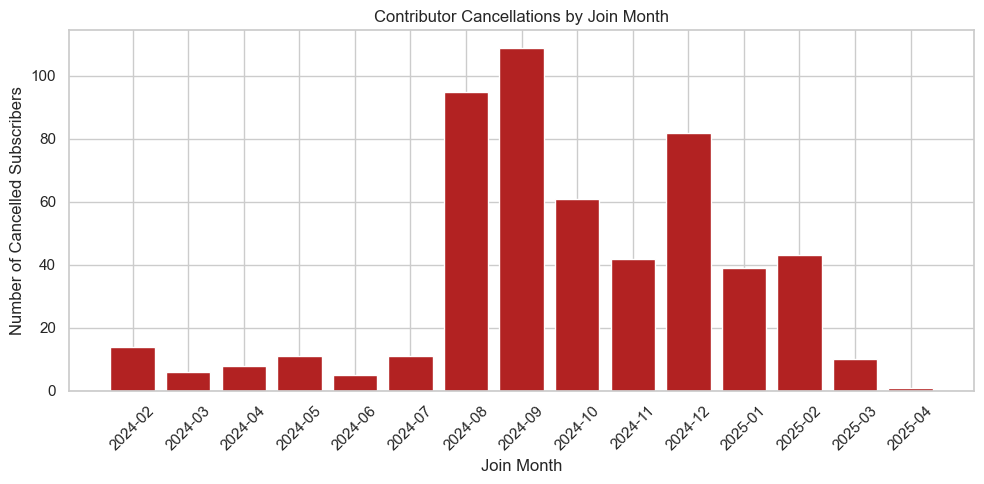

In [142]:
cancelled_users = df[df['subscription_status'].str.lower() == 'cancelled']
cancelled_users = cancelled_users.drop_duplicates(subset='subscriber_id')
cancelled_users['date_joined'] = pd.to_datetime(cancelled_users['date_joined'], errors='coerce')
cancelled_users['join_month'] = cancelled_users['date_joined'].dt.to_period('M')
cancel_counts = cancelled_users.groupby('join_month').size().reset_index(name='cancelled_users')

plt.figure(figsize=(10, 5))
plt.bar(cancel_counts['join_month'].astype(str), cancel_counts['cancelled_users'], color='firebrick')
plt.title('Contributor Cancellations by Join Month')
plt.xlabel('Join Month')
plt.ylabel('Number of Cancelled Subscribers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('contributor_cancellations_over_time.png', dpi=300)
plt.show()


### Analyising Transactions Failure Rate on Each Network

In [ ]:
df['transaction_status'] = df['transaction_status'].str.lower()
network_stats = df.groupby('network')['transaction_status'].value_counts().unstack().fillna(0)
network_stats['total'] = network_stats.sum(axis=1)
network_stats['failure_rate_%'] = (network_stats.get('failed', 0) / network_stats['total']) * 100

network_stats[['failed', 'total', 'failure_rate_%']]


transaction_status,failed,total,failure_rate_%
network,,,
ARTLTIGO,14,20,70.000000
MTN,186070,277908,66.953812
VODAFONE,21094,26111,80.785876


/var/folders/6g/jrq80zd95xs948nhk99scr7c0000gn/T/ipykernel_21270/776075595.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=network_stats.index, y=network_stats['failure_rate_%'], palette="Reds_r")


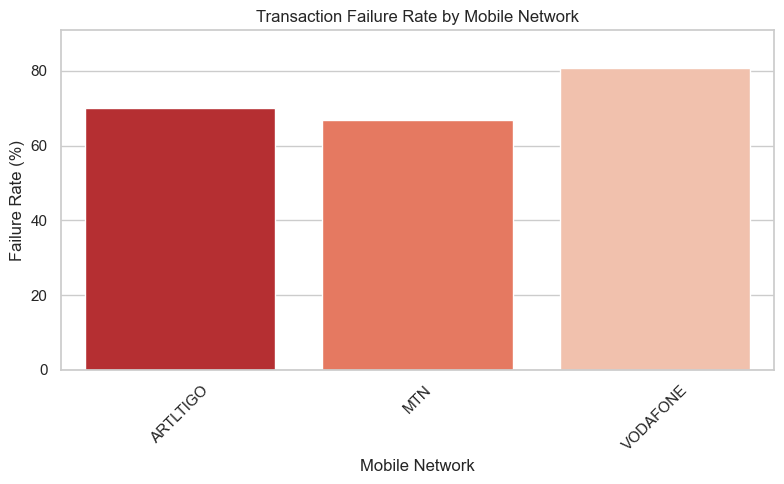

In [116]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(x=network_stats.index, y=network_stats['failure_rate_%'], palette="Reds_r")

plt.title("Transaction Failure Rate by Mobile Network")
plt.xlabel("Mobile Network")
plt.ylabel("Failure Rate (%)")
plt.ylim(0, network_stats['failure_rate_%'].max() + 10)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Common Reason for Contributor Deduction Failure

In [120]:
failed_txns = df[df['transaction_status'].str.lower() == 'failed']
reason_counts = failed_txns['status_reason'].value_counts()
# reason_counts.head()

status_reason
FAILED|Voluntary Pension Contribution                                                 668
TARGET_AUTHORIZATION_ERROR|Packet for Mandate 1707899623401 product ONEREC.D          390
Payment Failed|Retry Packet for Mandate 1708373307447 product ONEREC.M                388
TARGET_AUTHORIZATION_ERROR|Packet for Mandate 1708089719758 product ONEREC.D          387
TARGET_AUTHORIZATION_ERROR|Retry Packet for Mandate 1709066530674 product ONEREC.M    385
Name: count, dtype: int64

### Contributors Who Are Doing Close to Minimum Contributions

In [130]:
successful_df = df[df['transaction_status'].str.lower() == 'success']

successful_df['contribution_ratio'] = successful_df['amount_contributed'] / successful_df['cycle_min_amount']
close_to_minimum = successful_df[
    (successful_df['contribution_ratio'] >= 1.0) &
    (successful_df['contribution_ratio'] <= 1.2)
]

/var/folders/6g/jrq80zd95xs948nhk99scr7c0000gn/T/ipykernel_21270/3588047295.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  successful_df['contribution_ratio'] = successful_df['amount_contributed'] / successful_df['cycle_min_amount']


In [ ]:
total_contributors_success = successful_df.groupby('cycle_type')['subscriber_id'].nunique().reset_index(name='total_contributors')
close_min_contributors = close_to_minimum.groupby('cycle_type')['subscriber_id'].nunique().reset_index(name='close_to_min_contributors')
close_to_min_analysis = pd.merge(total_contributors_success, close_min_contributors, on='cycle_type', how='left')
close_to_min_analysis['close_to_min_contributors'] = close_to_min_analysis['close_to_min_contributors'].fillna(0)

close_to_min_analysis['percentage_close_to_min'] = round(
    (close_to_min_analysis['close_to_min_contributors'] / close_to_min_analysis['total_contributors']) * 100, 2
)

close_to_min_analysis


,cycle_type,total_contributors,close_to_min_contributors,percentage_close_to_min
0,Daily,1943,1082,55.69
1,Monthly,209,125,59.81
2,Weekly,617,390,63.21


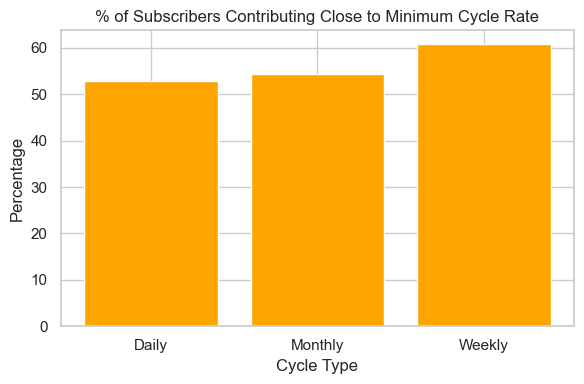

In [ ]:
plt.figure(figsize=(6, 4))
plt.bar(contribution_analysis['cycle_type'], contribution_analysis['percentage_close_to_min'], color='orange')
plt.title('% of Subscribers Contributing Close to Minimum Cycle Rate')
plt.ylabel('Percentage')
plt.xlabel('Cycle Type')
plt.tight_layout()
plt.savefig("percentage_close_to_min.png", dpi=300)
plt.show()

### Total Daily Contributions Since Inception

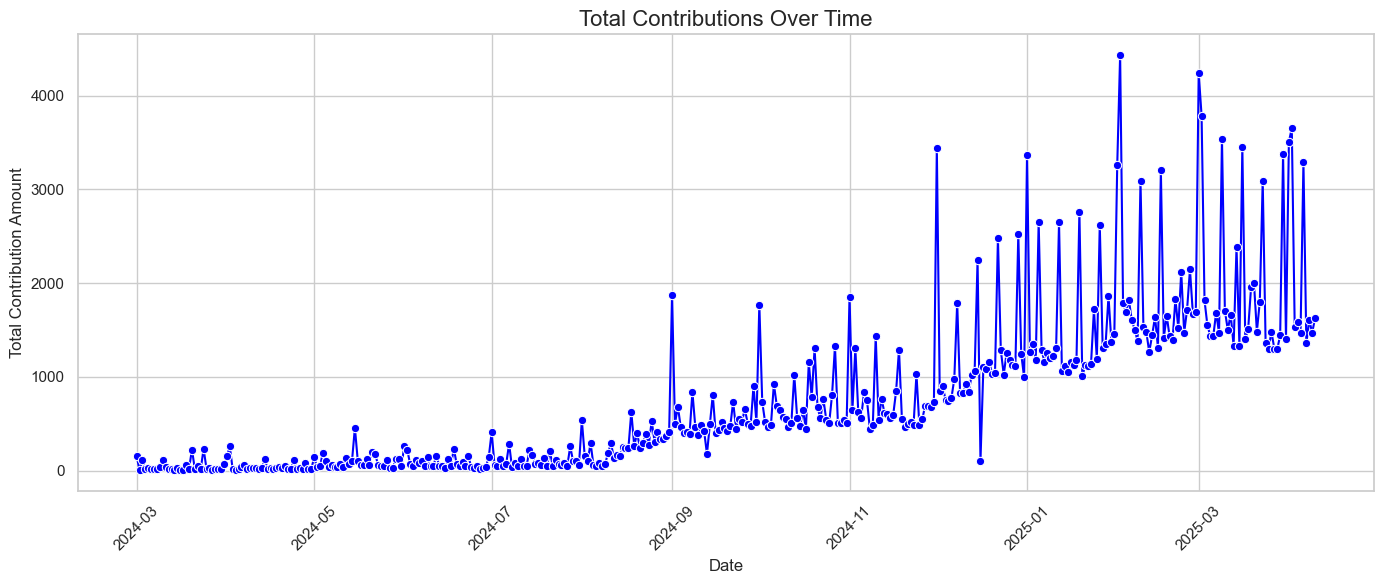

In [ ]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df_success = df[df['transaction_status'] == 'success'].copy()
daily_totals = df_success.groupby(df_success['transaction_date'].dt.date)['amount_contributed'].sum().reset_index()
daily_totals.columns = ['date', 'total_contribution']
plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_totals, x='date', y='total_contribution', marker='o', color='blue')

plt.title("Total Contributions Over Time", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Total Contribution Amount")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Day With Lowest Transaction After Launch

In [ ]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

start_date = pd.to_datetime('2024-08-20')
end_date = pd.to_datetime('today')

filtered_df = df[
    (df['transaction_status'] == 'success') &
    (df['transaction_date'] >= start_date) &
    (df['transaction_date'] <= end_date)
]

success_counts = (
    filtered_df
    .groupby(filtered_df['transaction_date'].dt.date)
    .size()
    .reset_index(name='success_count')
)

min_success = success_counts[success_counts['success_count'] == success_counts['success_count'].min()]

print("Day(s) with the lowest successful transactions from 20th August 2024 till now:")
print(min_success)

Day(s) with the lowest successful transactions from August 2024 till now:
    transaction_date  success_count
118       2024-12-16             37


#### Failure Reasons for Lowest Contributing Day

In [ ]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

failed_reasons = df[
    (df['transaction_date'].dt.date == pd.to_datetime('2024-12-16').date()) &
    (df['transaction_status'] == 'failed')
]

reason_counts = failed_reasons['status_reason'].value_counts().reset_index()
reason_counts.columns = ['status_reason', 'count']

print("Failure reasons on 2024-12-16:")
print(reason_counts)

Failure reasons on 2024-12-16:
                                          status_reason  count
0                 FAILED|Voluntary Pension Contribution     15
1         Payment Failed|Voluntary Pension Contribution      7
2     Payment Failed|Packet for Mandate 170689227382...      1
3     Payment Failed|Packet for Mandate 173167718854...      1
4     Payment Failed|Packet for Mandate 173220623206...      1
...                                                 ...    ...
1195  Payment Failed|Packet for Mandate 172563949274...      1
1196  Payment Failed|Packet for Mandate 172519722912...      1
1197  Payment Failed|Packet for Mandate 172608120515...      1
1198  Payment Failed|Packet for Mandate 172512847188...      1
1199  TARGET_AUTHORIZATION_ERROR|INITIAL DEBIT CALL ...      1

[1200 rows x 2 columns]
